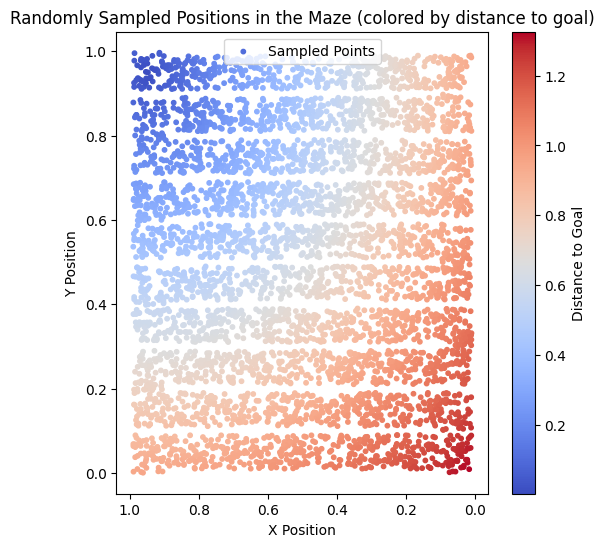

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from maze_env import MazeEnv
from maze import Maze

# Initialization of env.
maze = Maze(10, 10, 0, 0) 
env = MazeEnv(sz=10, maze=maze, start=np.array([0.05, 0.05]), goal=np.array([0.95, 0.95]),
               reward="distance", log=False, eval=False, dt=0.1, horizon=100, 
               wall_penalty=10, slide=1, image_freq=100)

# Function to generate valid points into the maze 
def generate_positions(env, num_samples=500, max_attempts=5000):
    positions = set()
    attempts = 0
    
    while len(positions) < num_samples and attempts < max_attempts:
        state = env.sample_open_state_continuous()
        
        # If the point lies on a wall, try again 
        if not env.point_collision(state[0], state[1]):
            positions.add(tuple(state))
        
        attempts += 1
    
    if len(positions) < num_samples:
        print(f"Warning: Only {len(positions)} unique positions generated out of {num_samples} requested.")
    
    return np.array(list(positions))

# Extended dead-end detection function
def is_dead_end_extended(env, x, y, radius=2):
    cx, cy = int(x * env.sz), int(y * env.sz)
    blocked_directions = 0
    
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            nx, ny = cx + dx, cy + dy
            if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
                blocked_directions += 1
            else:
                cell = env.maze.cell_at(nx, ny)
                if all(cell.walls.values()):
                    blocked_directions += 1
    
    return blocked_directions >= (radius * radius // 2)

# Compute the shortest path distance
def shortest_path_distance(env, x, y):
    from scipy.spatial import distance
    from queue import PriorityQueue
    
    cx, cy = int(x * env.sz), int(y * env.sz)
    goal_x, goal_y = int(env.goal[0] * env.sz), int(env.goal[1] * env.sz)
    
    frontier = PriorityQueue()
    frontier.put((0, (cx, cy)))
    cost_so_far = {(cx, cy): 0}
    
    while not frontier.empty():
        _, current = frontier.get()
        
        if current == (goal_x, goal_y):
            break
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            next_pos = (current[0] + dx, current[1] + dy)
            if next_pos in cost_so_far:
                continue
            
            if next_pos[0] < 0 or next_pos[0] >= env.maze.nx or next_pos[1] < 0 or next_pos[1] >= env.maze.ny:
                continue
            if all(env.maze.cell_at(next_pos[0], next_pos[1]).walls.values()):
                continue
            
            new_cost = cost_so_far[current] + 1
            cost_so_far[next_pos] = new_cost
            priority = new_cost + distance.euclidean(next_pos, (goal_x, goal_y))
            frontier.put((priority, next_pos))
    
    return cost_so_far.get((goal_x, goal_y), np.inf)

# Function to calculate the score points 
def compute_scores(env, positions):
    scores = []
    goal = np.array(env.goal)
    
    for pos in positions:
        x, y = pos
        
        # Distance from the goal 
        distance_to_goal = np.linalg.norm(goal - np.array([x, y]))
        
        # Distance from walls 
        epsilon = 0.05
        distances = [
            env.point_collision(x + epsilon, y),
            env.point_collision(x - epsilon, y),
            env.point_collision(x, y + epsilon),
            env.point_collision(x, y - epsilon)
        ]
        distance_from_wall = sum(1 for d in distances if not d) / len(distances)
        
        # Extended dead-end detection
        is_dead_end = is_dead_end_extended(env, x, y)
        
        # Shortest path distance
        path_distance = shortest_path_distance(env, x, y)
        
        scores.append((x, y, distance_to_goal, distance_from_wall, is_dead_end, path_distance))
    
    return scores

# Generate the points 
points_to_generate = 5000
positions = generate_positions(env, num_samples=points_to_generate, max_attempts=10*points_to_generate)

# Calculate the scores per each point 
scores = compute_scores(env, positions)

# Save points and scores 
df_positions = pd.DataFrame(scores, columns=["x", "y", "distance_to_goal", "distance_from_wall", "is_dead_end", "path_distance"])
df_positions.to_csv("positions.csv", index=False)

# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_goal"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to goal)")
plt.colorbar(label="Distance to Goal")
plt.show()
